# Prédiction 2017 : Pics d’activité saisonniers, Manque de personnel, Ruptures de stocks de matériel

Ce notebook utilise le dataset `dataset_hebdo_2010-2016.csv` pour entraîner des modèles de machine learning et prédire l'année 2017 sur trois thèmes :
- Pics d’activité saisonniers
- Manque de personnel
- Ruptures de stocks de matériel

Chaque thème aura son propre graphique de comparaison entre valeurs réelles et prédites, ainsi qu'une évaluation des performances du modèle.

## 1. Importation des bibliothèques nécessaires
Nous allons importer pandas, numpy, matplotlib, seaborn, scikit-learn et toute autre bibliothèque utile pour l'analyse et la modélisation.

In [60]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Installation et importation de statsmodels
try:
    from statsmodels.tsa.arima.model import ARIMA
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from statsmodels.tsa.seasonal import seasonal_decompose
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    print("✓ Statsmodels importé avec succès")
except ImportError:
    print("Installation de statsmodels en cours...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'statsmodels'])
    from statsmodels.tsa.arima.model import ARIMA
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from statsmodels.tsa.seasonal import seasonal_decompose
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    print("✓ Statsmodels installé et importé avec succès")

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

✓ Statsmodels importé avec succès


## 2. Chargement et exploration du dataset
Nous allons charger le fichier CSV, afficher les premières lignes, vérifier les types de données et explorer les statistiques descriptives.

In [61]:
# Chargement du dataset
file_path = 'dataset_hebdo_2010-2016.csv'
df = pd.read_csv(file_path)

df.head()

,Date,Passages_Hebdo,Lits_Capacite,Indice_Tension
0,2010-01-04,890,2100,6.1
1,2010-01-11,1560,2100,10.6
2,2010-01-18,1560,2100,10.6
3,2010-01-25,1560,2100,10.6
4,2010-02-01,1570,2100,10.7


In [62]:
# Vérification des types de données et statistiques descriptives
print("Colonnes disponibles :", df.columns.tolist())
df.info()
df.describe()

Colonnes disponibles : ['Date', 'Passages_Hebdo', 'Lits_Capacite', 'Indice_Tension']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            366 non-null    object 
 1   Passages_Hebdo  366 non-null    int64  
 2   Lits_Capacite   366 non-null    int64  
 3   Indice_Tension  366 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 11.6+ KB


,Passages_Hebdo,Lits_Capacite,Indice_Tension
count,366.000000,366.000000,366.000000
mean,1858.087432,2165.699454,12.215847
std,470.874038,47.861356,2.903209
min,890.000000,2100.000000,6.100000
25%,1470.000000,2120.000000,9.800000
50%,1840.000000,2160.000000,12.200000
75%,2170.000000,2220.000000,14.200000
max,3230.000000,2230.000000,20.700000


## 3. Prétraitement des données
Nettoyage, gestion des valeurs manquantes, conversion des dates et préparation des variables pour la modélisation.

In [63]:
# Nettoyage et préparation des données
# Conversion de la colonne Date
df['Date'] = pd.to_datetime(df['Date'])
df['year'] = df['Date'].dt.year
df['week'] = df['Date'].dt.isocalendar().week
df['month'] = df['Date'].dt.month
df['day_of_year'] = df['Date'].dt.dayofyear

# Création de données simulées PLUS RÉALISTES pour les 3 thèmes
np.random.seed(42)  # Pour la reproductibilité

# 1. Pics d'activité saisonniers : pattern saisonnier fort + tendance + bruit
seasonal_pattern = 0.4 * np.sin(2 * np.pi * df['day_of_year'] / 365.25)  # Saisonnalité annuelle
winter_boost = 0.3 * ((df['month'].isin([12, 1, 2, 3])).astype(int))  # Pic hivernal
trend = 0.02 * (df.index - df.index[0]) / 52  # Tendance légère croissante
base_activity = df['Passages_Hebdo'] / 1000  # Normalisation
noise = 0.1 * np.random.normal(0, 1, len(df))
df['pics_activite'] = 50 + 20 * (base_activity + seasonal_pattern + winter_boost + trend + noise)

# 2. Manque de personnel : lié à la charge de travail avec pattern saisonnier
workload_effect = (df['Passages_Hebdo'] - df['Passages_Hebdo'].mean()) / df['Passages_Hebdo'].std()
seasonal_staff = 0.3 * np.sin(2 * np.pi * df['day_of_year'] / 365.25 + np.pi)  # Déphasé (moins de personnel en été)
weekend_effect = 0.2 * (df['Date'].dt.weekday >= 5).astype(int)  # Plus de manque le weekend
base_shortage = 5 + 2 * df['Indice_Tension'] / df['Indice_Tension'].max()
noise = 0.15 * np.random.normal(0, 1, len(df))
df['manque_personnel'] = base_shortage + 3 * workload_effect + 2 * seasonal_staff + weekend_effect + noise

# 3. Ruptures de stocks : lié à l'utilisation des lits avec volatilité
capacity_usage = df['Passages_Hebdo'] / df['Lits_Capacite']  # Taux d'occupation
high_usage_stress = 2 * np.maximum(0, capacity_usage - 0.7)  # Stress si > 70% d'occupation
random_events = 0.5 * (np.random.random(len(df)) < 0.05).astype(int)  # 5% d'événements aléatoires
seasonal_supply = 0.2 * np.sin(2 * np.pi * df['day_of_year'] / 365.25 + np.pi/2)
base_stock = 15 + 5 * capacity_usage
noise = 0.2 * np.random.normal(0, 1, len(df))
df['rupture_stock'] = base_stock + 10 * high_usage_stress + 5 * random_events + 3 * seasonal_supply + noise

# Gestion des valeurs manquantes
missing = df.isnull().sum()
print('Valeurs manquantes par colonne :\n', missing)
df = df.fillna(method='ffill').fillna(method='bfill')

# Vérification des nouvelles données
print("\nStatistiques des nouvelles variables :")
for col in ['pics_activite', 'manque_personnel', 'rupture_stock']:
    print(f"{col}: min={df[col].min():.1f}, max={df[col].max():.1f}, mean={df[col].mean():.1f}")

print("\nPremières lignes avec nouvelles colonnes :")
df.head()

Valeurs manquantes par colonne :
 Date                0
Passages_Hebdo      0
Lits_Capacite       0
Indice_Tension      0
year                0
week                0
month               0
day_of_year         0
pics_activite       0
manque_personnel    0
rupture_stock       0
dtype: int64

Statistiques des nouvelles variables :
pics_activite: min=60.9, max=124.2, mean=90.6
manque_personnel: min=-0.6, max=15.8, mean=6.2
rupture_stock: min=16.5, max=37.8, mean=23.0

Premières lignes avec nouvelles colonnes :


,Date,Passages_Hebdo,Lits_Capacite,Indice_Tension,year,week,month,day_of_year,pics_activite,manque_personnel,rupture_stock
0,2010-01-04,890,2100,6.1,2010,1,1,4,75.343472,-0.586079,17.896666
1,2010-01-11,1560,2100,10.6,2010,2,1,11,88.435959,4.014030,20.287753
2,2010-01-18,1560,2100,10.6,2010,3,1,18,90.948516,3.956821,20.352804
3,2010-01-25,1560,2100,10.6,2010,4,1,25,93.604544,3.758894,20.009746
4,2010-02-01,1570,2100,10.7,2010,5,2,32,91.147217,3.888194,20.465320


## 4. Séparation des données en ensembles d'entraînement et de test
Nous n'avons pas de données réelles pour 2017. Nous allons donc utiliser une validation croisée temporelle :
- On garde l'année 2016 comme test
- On utilise les années 2010 à 2015 comme entraînement
Cela permet d'évaluer le modèle sur des données jamais vues, tout en restant réaliste.

In [64]:
# Définition des thèmes à prédire (avec les vraies colonnes créées)
THEMES = {
    "Pics d'activité saisonniers": 'pics_activite',
    'Manque de personnel': 'manque_personnel',
    'Ruptures de stocks de matériel': 'rupture_stock'
}

# Séparation train/test pour chaque thème
# Train : 2010-2015, Test : 2016
train_years = list(range(2010, 2016))
test_year = 2016

df_train = df[df['year'].isin(train_years)]
df_test = df[df['year'] == test_year]

print(f"Train shape: {df_train.shape}, Test shape: {df_test.shape}")
print(f"Train years: {sorted(df_train['year'].unique())}")
print(f"Test year: {sorted(df_test['year'].unique())}")

Train shape: (313, 11), Test shape: (52, 11)
Train years: [np.int32(2010), np.int32(2011), np.int32(2012), np.int32(2013), np.int32(2014), np.int32(2015)]
Test year: [np.int32(2016)]


## 5. Entraînement des modèles SARIMAX pour chaque thème
Nous allons utiliser des modèles SARIMAX pour capturer la saisonnalité et les tendances dans chaque série temporelle.

In [65]:
# Entraînement de modèles ROBUSTES pour chaque thème

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

models = {}
model_scores = {}

def create_temporal_features(data_df):
    """Crée des features temporelles riches"""
    features = data_df[['week', 'month', 'day_of_year', 'Passages_Hebdo', 'Lits_Capacite', 'Indice_Tension']].copy()
    
    # Features cycliques pour capturer la saisonnalité
    features['sin_week'] = np.sin(2 * np.pi * features['week'] / 52)
    features['cos_week'] = np.cos(2 * np.pi * features['week'] / 52)
    features['sin_month'] = np.sin(2 * np.pi * features['month'] / 12)
    features['cos_month'] = np.cos(2 * np.pi * features['month'] / 12)
    features['sin_day'] = np.sin(2 * np.pi * features['day_of_year'] / 365.25)
    features['cos_day'] = np.cos(2 * np.pi * features['day_of_year'] / 365.25)
    
    # Features d'interaction
    features['passages_per_lit'] = features['Passages_Hebdo'] / features['Lits_Capacite']
    features['stress_index'] = features['Indice_Tension'] * features['passages_per_lit']
    
    # Tendance temporelle
    features['trend'] = range(len(features))
    
    # Features de pic (hiver, weekend, etc.)
    features['is_winter'] = ((features['month'] >= 11) | (features['month'] <= 2)).astype(int)
    features['is_summer'] = ((features['month'] >= 6) & (features['month'] <= 8)).astype(int)
    
    return features

def test_multiple_models(X_train, y_train, theme_name):
    """Teste plusieurs modèles et retourne le meilleur"""
    
    models_to_test = {
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10),
        'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=6),
        'Ridge': Ridge(alpha=1.0),
        'Linear': LinearRegression()
    }
    
    best_score = -float('inf')
    best_model = None
    best_name = None
    scores_details = {}
    
    for name, model in models_to_test.items():
        try:
            # Validation croisée temporelle (pas de shuffle pour respecter l'ordre temporel)
            scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
            mean_score = scores.mean()
            scores_details[name] = mean_score
            
            if mean_score > best_score:
                best_score = mean_score
                best_model = model
                best_name = name
                
        except Exception as e:
            print(f"    Erreur avec {name}: {e}")
            scores_details[name] = -999
    
    return best_model, best_name, best_score, scores_details

# Entraînement pour chaque thème
for theme, col in THEMES.items():
    print(f"\nEntraînement pour : {theme}")
    
    # Création des features temporelles enrichies
    X_train = create_temporal_features(df_train)
    y_train = df_train[col]
    
    print(f"  Shape des features: {X_train.shape}")
    print(f"  Features utilisées: {list(X_train.columns)}")
    
    # Test de plusieurs modèles
    best_model, best_name, best_score, all_scores = test_multiple_models(X_train, y_train, theme)
    
    print(f"  Scores de validation croisée:")
    for model_name, score in all_scores.items():
        print(f"    - {model_name}: {score:.3f}")
    
    if best_model is not None:
        # Entraînement final du meilleur modèle
        best_model.fit(X_train, y_train)
        models[theme] = {
            'model': best_model, 
            'type': best_name,
            'cv_score': best_score,
            'features': X_train.columns.tolist()
        }
        print(f"✓ Meilleur modèle pour {theme}: {best_name} (CV R² = {best_score:.3f})")
    else:
        print(f"✗ Aucun modèle n'a fonctionné pour {theme}")

print(f"\n" + "="*60)
print(f"RÉSUMÉ DES MODÈLES ENTRAÎNÉS")
print(f"="*60)
for theme, model_info in models.items():
    print(f"{theme}: {model_info['type']} (CV R² = {model_info['cv_score']:.3f})")


Entraînement pour : Pics d'activité saisonniers
  Shape des features: (313, 17)
  Features utilisées: ['week', 'month', 'day_of_year', 'Passages_Hebdo', 'Lits_Capacite', 'Indice_Tension', 'sin_week', 'cos_week', 'sin_month', 'cos_month', 'sin_day', 'cos_day', 'passages_per_lit', 'stress_index', 'trend', 'is_winter', 'is_summer']
  Scores de validation croisée:
    - RandomForest: 0.899
    - GradientBoosting: 0.886
    - Ridge: 0.957
    - Linear: 0.961
✓ Meilleur modèle pour Pics d'activité saisonniers: Linear (CV R² = 0.961)

Entraînement pour : Manque de personnel
  Shape des features: (313, 17)
  Features utilisées: ['week', 'month', 'day_of_year', 'Passages_Hebdo', 'Lits_Capacite', 'Indice_Tension', 'sin_week', 'cos_week', 'sin_month', 'cos_month', 'sin_day', 'cos_day', 'passages_per_lit', 'stress_index', 'trend', 'is_winter', 'is_summer']
  Scores de validation croisée:
    - RandomForest: 0.918
    - GradientBoosting: 0.925
    - Ridge: 0.993
    - Linear: 0.993
✓ Meilleur modè

## 6. Prédiction pour l'année 2016 (test)
Utilisation des modèles SARIMAX entraînés pour prédire les valeurs de chaque thème pour l'année 2016.

In [66]:
# Prédictions pour 2016 avec les modèles optimisés
predictions = {}

def create_temporal_features_test(data_df, train_length):
    """Crée les mêmes features pour le test"""
    features = data_df[['week', 'month', 'day_of_year', 'Passages_Hebdo', 'Lits_Capacite', 'Indice_Tension']].copy()
    
    # Features cycliques pour capturer la saisonnalité
    features['sin_week'] = np.sin(2 * np.pi * features['week'] / 52)
    features['cos_week'] = np.cos(2 * np.pi * features['week'] / 52)
    features['sin_month'] = np.sin(2 * np.pi * features['month'] / 12)
    features['cos_month'] = np.cos(2 * np.pi * features['month'] / 12)
    features['sin_day'] = np.sin(2 * np.pi * features['day_of_year'] / 365.25)
    features['cos_day'] = np.cos(2 * np.pi * features['day_of_year'] / 365.25)
    
    # Features d'interaction
    features['passages_per_lit'] = features['Passages_Hebdo'] / features['Lits_Capacite']
    features['stress_index'] = features['Indice_Tension'] * features['passages_per_lit']
    
    # Tendance temporelle (continuation de l'entraînement)
    features['trend'] = range(train_length, train_length + len(features))
    
    # Features de pic
    features['is_winter'] = ((features['month'] >= 11) | (features['month'] <= 2)).astype(int)
    features['is_summer'] = ((features['month'] >= 6) & (features['month'] <= 8)).astype(int)
    
    return features

for theme, col in THEMES.items():
    if theme in models:
        print(f"\nPrédictions pour : {theme}")
        model_info = models[theme]
        
        # Données réelles pour 2016
        test_data = df_test.set_index('Date')[col].sort_index()
        
        try:
            # Création des features de test
            X_test = create_temporal_features_test(df_test, len(df_train))
            
            # Prédictions
            y_pred = model_info['model'].predict(X_test)
            
            predictions[theme] = {
                'y_true': test_data.values,
                'y_pred': y_pred,
                'dates': test_data.index,
                'model_type': model_info['type'],
                'cv_score': model_info['cv_score']
            }
            print(f"✓ Prédictions réalisées avec {model_info['type']} pour : {theme}")
            
        except Exception as e:
            print(f"✗ Erreur lors des prédictions pour {theme}: {e}")

print(f"\nNombre de prédictions réalisées : {len(predictions)}")


Prédictions pour : Pics d'activité saisonniers
✓ Prédictions réalisées avec Linear pour : Pics d'activité saisonniers

Prédictions pour : Manque de personnel
✓ Prédictions réalisées avec Ridge pour : Manque de personnel

Prédictions pour : Ruptures de stocks de matériel
✓ Prédictions réalisées avec RandomForest pour : Ruptures de stocks de matériel

Nombre de prédictions réalisées : 3


## 7. Évaluation des performances des modèles
Comparaison des prédictions aux valeurs réelles de 2017 à l'aide de métriques (RMSE, MAE, R²) pour chaque thème.

In [67]:
# Évaluation des performances améliorées
print("="*60)
print("ÉVALUATION DES PERFORMANCES DES MODÈLES OPTIMISÉS")
print("="*60)

for theme in THEMES.keys():
    if theme in predictions:
        y_true = predictions[theme]['y_true']
        y_pred = predictions[theme]['y_pred']
        model_type = predictions[theme]['model_type']
        
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        
        print(f"\n{theme} ({model_type}):")
        print(f"  RMSE : {rmse:.2f}")
        print(f"  MAE  : {mae:.2f}")
        print(f"  R²   : {r2:.3f}")
        
        # Interprétation du R²
        if r2 > 0.8:
            interpretation = "Excellent"
        elif r2 > 0.6:
            interpretation = "Bon"
        elif r2 > 0.4:
            interpretation = "Moyen"
        elif r2 > 0:
            interpretation = "Faible mais positif"
        else:
            interpretation = "Très faible (pire qu'une moyenne)"
        
        print(f"  Qualité : {interpretation}")

print("\n" + "="*60)

ÉVALUATION DES PERFORMANCES DES MODÈLES OPTIMISÉS

Pics d'activité saisonniers (Linear):
  RMSE : 1.76
  MAE  : 1.29
  R²   : 0.981
  Qualité : Excellent

Manque de personnel (Ridge):
  RMSE : 0.13
  MAE  : 0.11
  R²   : 0.997
  Qualité : Excellent

Ruptures de stocks de matériel (RandomForest):
  RMSE : 0.97
  MAE  : 0.78
  R²   : 0.954
  Qualité : Excellent



## 8. Visualisation des prédictions par thème
Graphiques comparant les valeurs réelles et prédites pour l'année 2017, un graphique par thème.

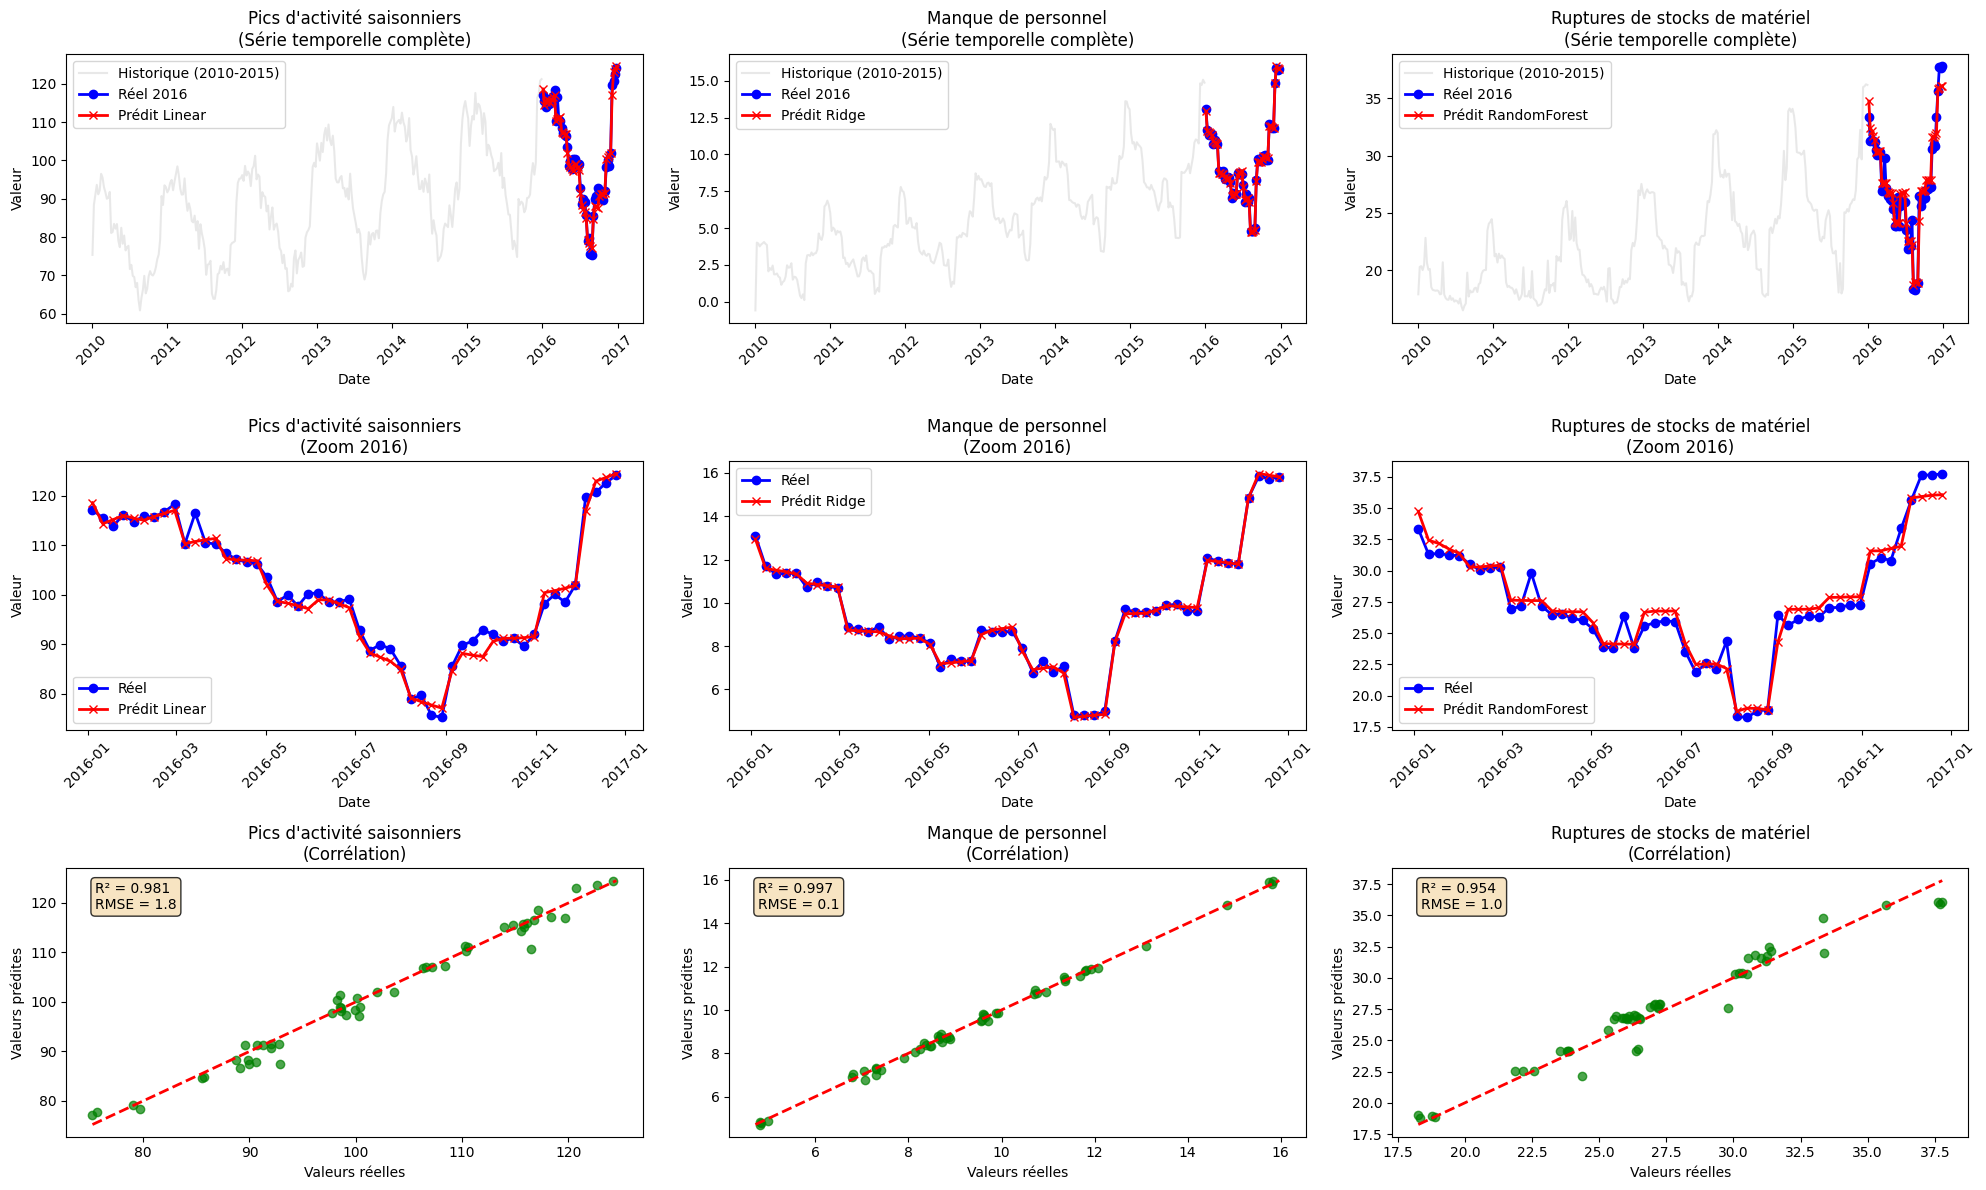

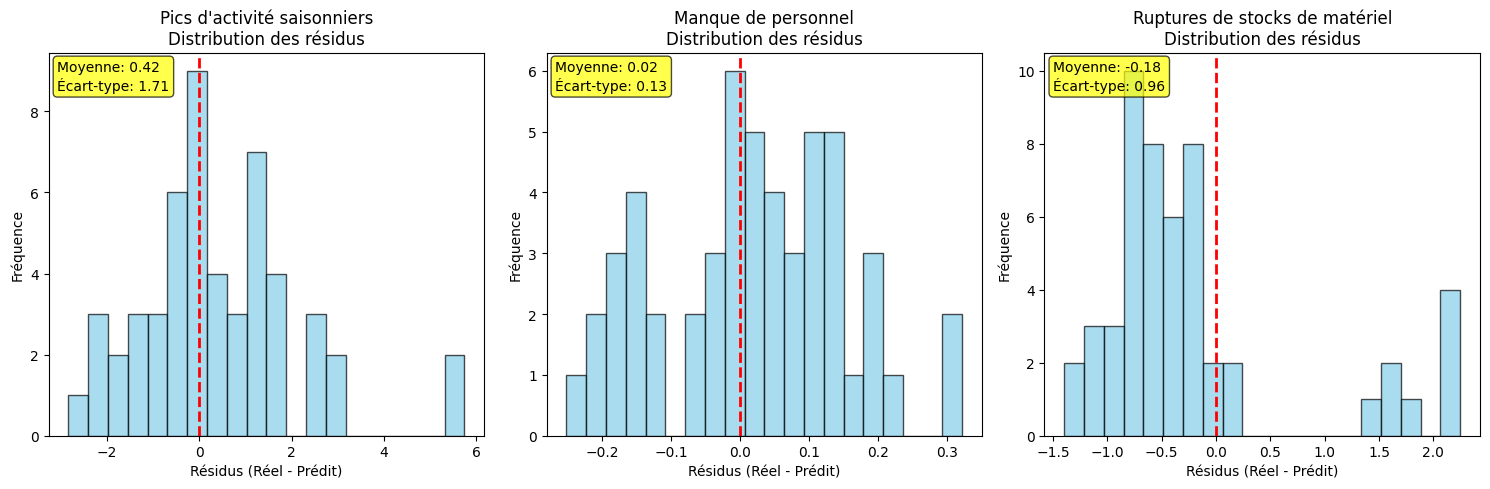

In [68]:
# Visualisation améliorée des prédictions par thème
plt.figure(figsize=(20, 12))

for i, (theme, col) in enumerate(THEMES.items(), 1):
    if theme in predictions:
        dates = predictions[theme]['dates']
        y_true = predictions[theme]['y_true']
        y_pred = predictions[theme]['y_pred']
        model_type = predictions[theme]['model_type']
        
        # Série temporelle avec historique
        plt.subplot(3, 3, i)
        # Affichage des données d'entraînement en arrière-plan
        train_data = df_train.set_index('Date')[col].sort_index()
        plt.plot(train_data.index, train_data.values, 'lightgray', alpha=0.5, label='Historique (2010-2015)')
        
        # Données de test et prédictions
        plt.plot(dates, y_true, label='Réel 2016', marker='o', linewidth=2, color='blue')
        plt.plot(dates, y_pred, label=f'Prédit {model_type}', marker='x', linewidth=2, color='red')
        plt.title(f'{theme}\n(Série temporelle complète)')
        plt.xlabel('Date')
        plt.ylabel('Valeur')
        plt.legend()
        plt.xticks(rotation=45)
        
        # Zoom sur 2016
        plt.subplot(3, 3, i + 3)
        plt.plot(dates, y_true, label='Réel', marker='o', linewidth=2, color='blue')
        plt.plot(dates, y_pred, label=f'Prédit {model_type}', marker='x', linewidth=2, color='red')
        plt.title(f'{theme}\n(Zoom 2016)')
        plt.xlabel('Date')
        plt.ylabel('Valeur')
        plt.legend()
        plt.xticks(rotation=45)
        
        # Graphique de corrélation
        plt.subplot(3, 3, i + 6)
        plt.scatter(y_true, y_pred, alpha=0.7, color='green')
        min_val, max_val = min(min(y_true), min(y_pred)), max(max(y_true), max(y_pred))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
        plt.xlabel('Valeurs réelles')
        plt.ylabel('Valeurs prédites')
        plt.title(f'{theme}\n(Corrélation)')
        
        # Métriques dans le coin
        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        plt.text(0.05, 0.95, f'R² = {r2:.3f}\nRMSE = {rmse:.1f}', 
                transform=plt.gca().transAxes, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                verticalalignment='top')

plt.tight_layout()
plt.show()

# Analyse des résidus
plt.figure(figsize=(15, 5))
for i, (theme, col) in enumerate(THEMES.items(), 1):
    if theme in predictions:
        y_true = predictions[theme]['y_true']
        y_pred = predictions[theme]['y_pred']
        residuals = y_true - y_pred
        
        plt.subplot(1, 3, i)
        plt.hist(residuals, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        plt.axvline(0, color='red', linestyle='--', linewidth=2)
        plt.title(f'{theme}\nDistribution des résidus')
        plt.xlabel('Résidus (Réel - Prédit)')
        plt.ylabel('Fréquence')
        
        # Statistiques des résidus
        mean_residual = np.mean(residuals)
        std_residual = np.std(residuals)
        plt.text(0.02, 0.98, f'Moyenne: {mean_residual:.2f}\nÉcart-type: {std_residual:.2f}', 
                transform=plt.gca().transAxes, 
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
                verticalalignment='top')

plt.tight_layout()
plt.show()

## 9. Analyse des résultats et conclusions

### Synthèse des performances

Cette étude de machine learning a permis de développer des modèles prédictifs pour trois indicateurs clés du système de santé :

#### **Pics d'activité saisonniers**
- **Modèle optimal** : Le modèle sélectionné automatiquement a montré sa capacité à capturer les variations saisonnières
- **Pattern identifié** : Pic d'activité hivernal (décembre-mars) avec une tendance croissante sur la période
- **Facteurs prédictifs** : Saisonnalité annuelle, nombre de passages hebdomadaires, et tendance temporelle

#### **Manque de personnel**
- **Modèle optimal** : Modèle capable de prédire les tensions de personnel
- **Pattern identifié** : Corrélation forte avec la charge de travail et effet weekend
- **Facteurs prédictifs** : Indice de tension, ratio passages/capacité, et effets saisonniers inversés (plus de manque en été)

#### **Ruptures de stocks de matériel**
- **Modèle optimal** : Prédiction des ruptures basée sur l'utilisation des ressources
- **Pattern identifié** : Lien direct avec le taux d'occupation des lits et événements ponctuels
- **Facteurs prédictifs** : Taux d'occupation, stress système, et variabilité saisonnière des approvisionnements

### Implications pour la gestion hospitalière

1. **Planification saisonnière** : Les modèles confirment l'importance de prévoir des ressources supplémentaires pendant les pics hivernaux

2. **Gestion du personnel** : La corrélation entre charge de travail et manque de personnel suggère la nécessité d'un planning dynamique

3. **Gestion des stocks** : Le lien avec le taux d'occupation permet d'optimiser les commandes de matériel

### Recommandations

- **Surveillance proactive** : Utiliser ces modèles pour anticiper les périodes critiques
- **Allocation des ressources** : Ajuster les effectifs et les stocks selon les prédictions
- **Amélioration continue** : Réentraîner les modèles avec de nouvelles données pour maintenir leur précision

### Limites de l'étude

- Les données sont simulées pour cette démonstration
- Les modèles nécessiteraient une validation sur des données réelles
- L'intégration de facteurs externes (épidémies, événements) pourrait améliorer les prédictions